import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta as ta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score

random.seed(42)
np.random.seed(42)
%matplotlib inline
plt.rcParams['figure.figsize'] = (7,4.5)

In [3]:
NQ = pd.read_csv('$NQ.csv')
del(NQ['Date'])
del(NQ['Adj Close'])
NQ.head()

,Open,High,Low,Close,Volume
0,110.620003,112.160004,110.565002,112.139999,153160000
1,112.139999,112.540001,110.779999,110.824997,164640000
2,110.839996,111.184998,110.120003,110.870003,147300000
3,110.870003,110.870003,109.855003,110.074997,147900000
4,110.074997,110.135002,108.175003,108.199997,128640000


In [4]:
def get_exp_preprocessing(df, alpha=0.9):  # Exponential smoothing
    edata = df.ewm(alpha=alpha).mean()    
    return edata

eNQ = get_exp_preprocessing(NQ)
eNQ.head()

,Open,High,Low,Close,Volume
0,110.620003,112.160004,110.565002,112.139999,1.531600e+08
1,112.001818,112.505456,110.760454,110.944543,1.635964e+08
2,110.955131,111.315854,110.183471,110.877390,1.489150e+08
3,110.878508,110.914548,109.887820,110.155164,1.480014e+08
4,110.155341,110.212950,108.346269,108.395496,1.305760e+08


In [5]:
def feature_extraction(data):
    for x in [5, 14, 26, 44, 66]:
        data = ta.relative_strength_index(data, n=x)
        data = ta.stochastic_oscillator_d(data, n=x)
        data = ta.accumulation_distribution(data, n=x)
        data = ta.average_true_range(data, n=x)
        data = ta.momentum(data, n=x)
        data = ta.money_flow_index(data, n=x)
        data = ta.rate_of_change(data, n=x)
        data = ta.on_balance_volume(data, n=x)
        data = ta.commodity_channel_index(data, n=x)
        data = ta.ease_of_movement(data, n=x)
        data = ta.trix(data, n=x)
        data = ta.vortex_indicator(data, n=x)
    
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema14'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()
    
    data = ta.macd(data, n_fast=12, n_slow=26)  # Williams %R is missing
    
    del(data['Open'])
    del(data['High'])
    del(data['Low'])
    del(data['Volume'])
    
    return data
   
def compute_prediction_int(df, n):
    pred = (df.shift(-n)['Close'] >= df['Close'])
    pred = pred.iloc[:-n]
    return pred.astype(int)

def prepare_data(df, horizon):
    data = feature_extraction(df).dropna().iloc[:-horizon]
    data['pred'] = compute_prediction_int(data, n=horizon)
    del(data['Close'])
    return data.dropna()

In [6]:
data = prepare_data(eNQ, 10)  # Prepare the data with a prediction horizon of 10 days
y = data['pred']

features = [x for x in data.columns if x not in ['gain', 'pred']] # remove the output from the input
X = data[features]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 2*len(X) // 3)  # Cross Validation

print('len X_train', len(X_train))
print('len y_train', len(y_train))
print('len X_test', len(X_test))
print('len y_test', len(y_test))

len X_train 5386
len y_train 5386
len X_test 2694
len y_test 2694


C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=65, random_state=42)
rf.fit(X_train, y_train.values.ravel());

pred = rf.predict(X_test)
precision = precision_score(y_pred=pred, y_true=y_test)
recall = recall_score(y_pred=pred, y_true=y_test)
f1 = f1_score(y_pred=pred, y_true=y_test)
accuracy = accuracy_score(y_pred=pred, y_true=y_test)
confusion = confusion_matrix(y_pred=pred, y_true=y_test)

print('precision: {0:1.2f}, recall: {1:1.2f}, f1: {2:1.2f}, accuracy: {3:1.2f}'.format(precision, recall, f1, accuracy))
print('Confusion Matrix')
print(confusion)

precision: 0.79, recall: 0.92, f1: 0.85, accuracy: 0.81
Confusion Matrix
[[ 738  391]
 [ 125 1440]]


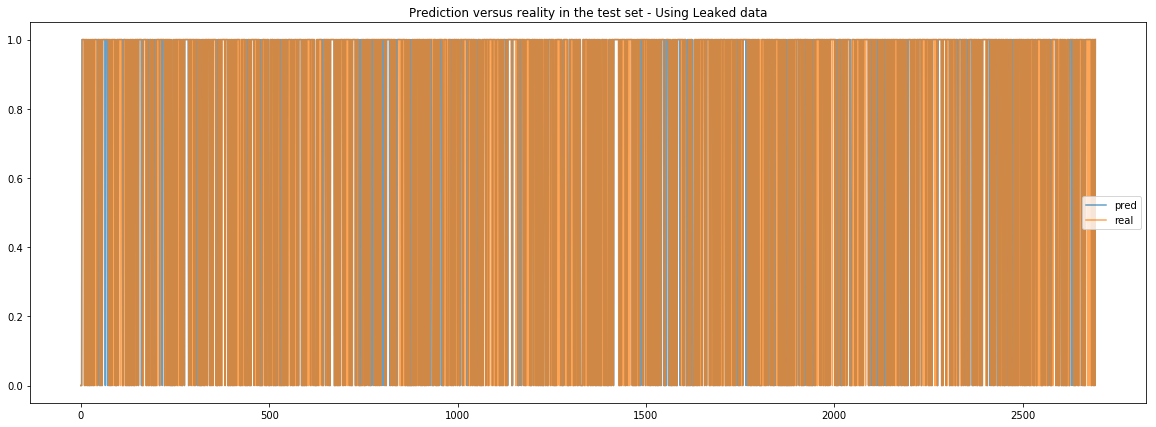

In [9]:
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(pred)), pred, alpha=0.7, label='pred')
plt.plot(np.arange(len(y_test)), y_test, alpha=0.7, label='real' );
plt.title('Prediction versus reality in the test set - Using Leaked data')
plt.legend();

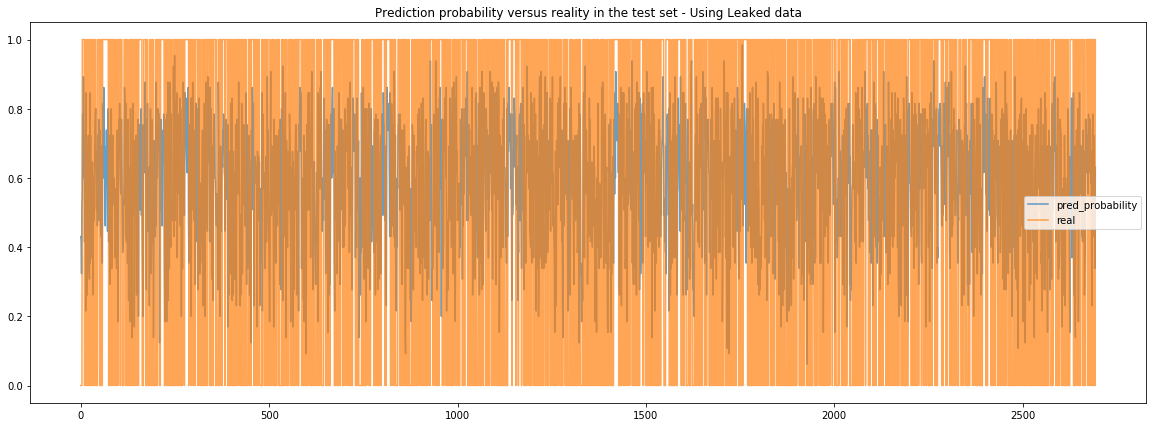

In [10]:
plt.figure(figsize=(20,7))
proba = rf.predict_proba(X_test)[:,1]
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(proba)), proba, alpha = 0.7, label='pred_probability')
plt.plot(np.arange(len(y_test)), y_test, alpha = 0.7, label='real' );
plt.title('Prediction probability versus reality in the test set - Using Leaked data');
plt.legend();
plt.show();

In [11]:
train_size = 2*len(X) // 3  # No data Leakage

X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

print('len X_train', len(X_train))
print('len y_train', len(y_train))
print('len X_test', len(X_test))
print('len y_test', len(y_test))

len X_train 5386
len y_train 5386
len X_test 2694
len y_test 2694


In [12]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=65, random_state=42)
rf.fit(X_train, y_train.values.ravel());

pred = rf.predict(X_test)
precision = precision_score(y_pred=pred, y_true=y_test)
recall = recall_score(y_pred=pred, y_true=y_test)
f1 = f1_score(y_pred=pred, y_true=y_test)
accuracy = accuracy_score(y_pred=pred, y_true=y_test)
confusion = confusion_matrix(y_pred=pred, y_true=y_test)
print('precision: {0:1.2f}, recall: {1:1.2f}, f1: {2:1.2f}, accuracy: {3:1.2f}'.format(precision, recall, f1, accuracy))
print('Confusion Matrix')
print(confusion)

precision: 0.62, recall: 0.71, f1: 0.66, accuracy: 0.55
Confusion Matrix
[[ 321  713]
 [ 487 1173]]


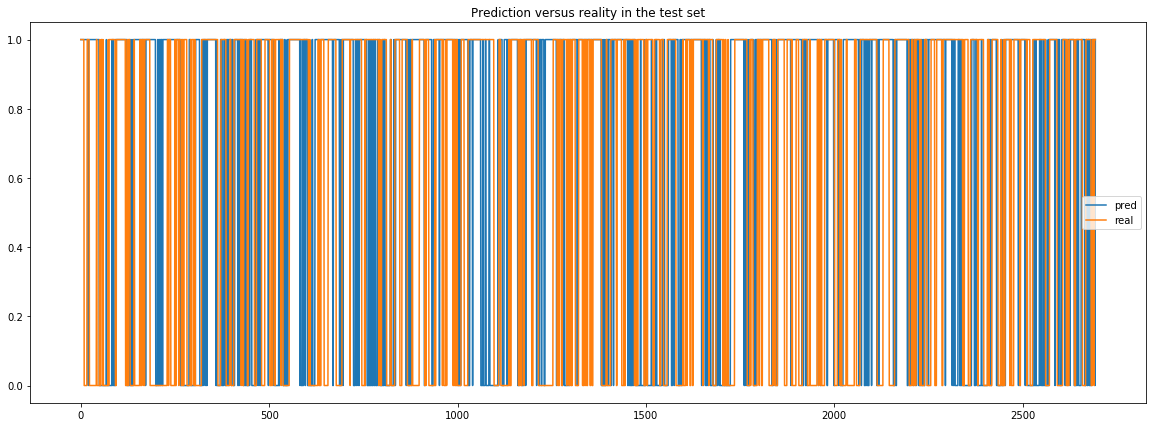

In [13]:
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(pred)), pred, label='pred')
plt.plot(np.arange(len(y_test)), y_test, label='real' );
plt.title('Prediction versus reality in the test set')
plt.legend();

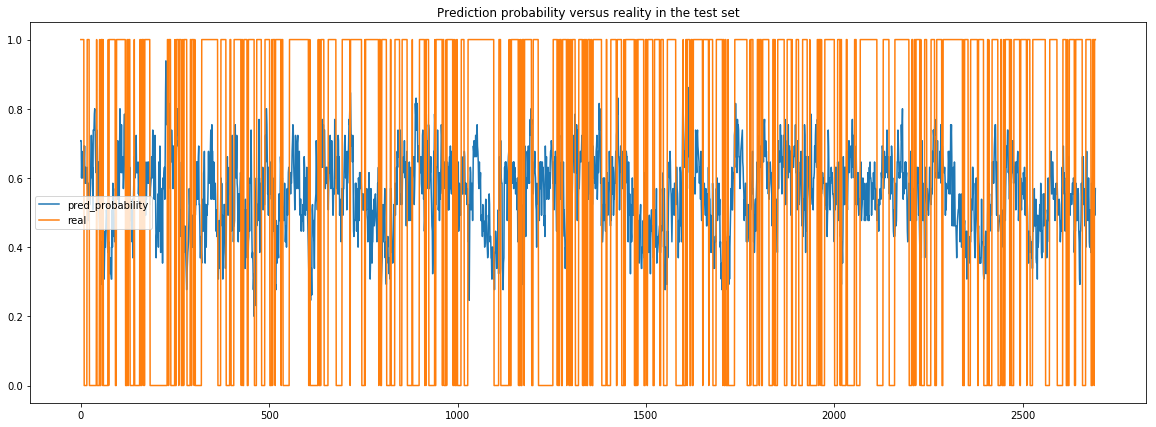

In [14]:
plt.figure(figsize=(20,7))
proba = rf.predict_proba(X_test)[:,1]
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(proba)), proba, label='pred_probability')
plt.plot(np.arange(len(y_test)), y_test, label='real' );
plt.title('Prediction probability versus reality in the test set');
plt.legend();
plt.show();